# Projeto Final de Machine Learning

<strong>Membros:</strong>
- João Laet
- Nicolas Cho
- Roger Pina

<strong>Professor:</strong>
- Fábio Ayres

<strong>Github:</strong>
- https://github.com/NicolasCho/projeto_ML

# Imports

In [ ]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import os
#from keras import tensorflow

---

# Data Exploration

## Data Section 1 - The basics

In [ ]:
os.chdir("data/NCAA/")

In [56]:
df_teams = pd.read_csv("Teams.csv")
seasons = pd.read_csv("Seasons.csv")
NCAATourneySeeds = pd.read_csv("NCAATourneySeeds.csv")
RegularSeasonCompactResults = pd.read_csv("RegularSeasonCompactResults.csv")
NCAATourneyCompactResults = pd.read_csv("NCAATourneyCompactResults.csv")
SampleSubmissionStage1 = pd.read_csv("SampleSubmissionStage1.csv")

### Teams

In [ ]:
df_teams

### SeasonsEloRating

In [ ]:
seasons

### Seeds

In [ ]:
NCAATourneySeeds

In [ ]:
NCAATourneySeeds = NCAATourneySeeds[NCAATourneySeeds['Season'] < 2014]

### RegularSeasonCompactResults

In [57]:
RegularSeasonCompactResults

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
150679,2017,132,1276,71,1458,56,N,0
150680,2017,132,1343,71,1463,59,N,0
150681,2017,132,1348,70,1433,63,N,0
150682,2017,132,1374,71,1153,56,N,0


In [ ]:
RegularSeasonCompactResults = RegularSeasonCompactResults[RegularSeasonCompactResults['Season'] < 2014]

### NCAATourneyCompactResults

In [ ]:
NCAATourneyCompactResults 

In [ ]:
NCAATourneyCompactResults = NCAATourneyCompactResults[NCAATourneyCompactResults['Season'] < 2014]

### SampleSubmissionStage1

In [45]:
SampleSubmissionStage1

,ID,Pred
0,2014_1107_1110,0.5
1,2014_1107_1112,0.5
2,2014_1107_1113,0.5
3,2014_1107_1124,0.5
4,2014_1107_1140,0.5
...,...,...
9107,2017_1455_1458,0.5
9108,2017_1455_1462,0.5
9109,2017_1457_1458,0.5
9110,2017_1457_1462,0.5


In [ ]:
#pbp2010 = pd.read_csv('./mens-machine-learning-competition-2018/PlayByPlay_2010/Events_2010.csv')

---

# Feature Engineering

## Elo Rating

In [ ]:
def win_probs(wTeam_elo, lTeam_elo, home_court_advantage, WLoc):
    w = math.pow(10, wTeam_elo/400)
    l = math.pow(10, lTeam_elo/400)
    a = math.pow(10, home_court_advantage/400) 
    
    if WLoc == 'H':
        denom = l + a*w
        wTeam_prob = a*w / denom
        lTeam_prob = l / denom   
        
    elif WLoc == 'A':
        denom = a*l + w
        wTeam_prob = w / denom
        lTeam_prob = a*l / denom   
        
    else:
        denom = l + w
        wTeam_prob = a / denom
        lTeam_prob = l / denom 
        
    return wTeam_prob, lTeam_prob

In [ ]:
def elo_k(MOV, elo_diff):
    k = 20
    if MOV>0:
        multiplier=(MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier=(-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
    return k*multiplier

In [ ]:
def update_elo(game, df_eloActual):
    home_court_advantage = 100
    wTeam = game['WTeamID']
    wTeam_elo = int(df_eloActual[df_eloActual['TeamID'] == wTeam][str(game['Season'])])
    wTeam_score = game['WScore']
    #print(wTeam, wTeam_elo, wTeam_score)
    
    lTeam = game['LTeamID']
    lTeam_elo = int(df_eloActual[df_eloActual['TeamID'] == lTeam][str(game['Season'])])
    lTeam_score = game['LScore']
    #print(lTeam, lTeam_elo, lTeam_score)
        
    wTeam_prob, lTeam_prob = win_probs(wTeam_elo, lTeam_elo, home_court_advantage, game['WLoc'])
    
    k = elo_k(wTeam_score - lTeam_score, wTeam_elo - lTeam_elo)
        
    updated_wTeam_elo = wTeam_elo + k * (1 - wTeam_prob) 
    updated_lTeam_elo = lTeam_elo + k * (0 - lTeam_prob)
    
    return updated_wTeam_elo, updated_lTeam_elo

<strong>1 - RegularSeason</strong>
Campeonato antes da NCAA - 150K linhas de jogos (1985 - 2017)

<strong>2 - NCAA Tourney</strong>
2K linhas de jogos (1985 - 2017)

In [ ]:
# 1
df_RegularSeason = RegularSeasonCompactResults.copy() # Dataframe que será adicinado o elo rating

# 2 
df_NCAATourney = NCAATourneyCompactResults.copy() # Dataframe que será adicinado o elo rating

In [ ]:
df_elo = df_teams.copy().drop(columns=['TeamName', 'FirstD1Season', 'LastD1Season'])

for season in df_NCAATourney['Season'].unique():

  if season == 1985:
    df_elo[str(season)] = 1500
  else:
    df_elo[str(season)] = list(df_elo[str(season - 1)])

  #1 - Calcular o Elo Rating na Regular Season
  for index, row in df_RegularSeason[df_RegularSeason['Season'] == season].iterrows():
    updated_wTeam_elo, updated_lTeam_elo = update_elo(row, df_elo)

    #wTeam
    idx = df_elo[df_elo['TeamID'] == row['WTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_wTeam_elo
    df_RegularSeason.loc[index, 'WElo'] = updated_wTeam_elo
    
    #lTeam
    idx = df_elo[df_elo['TeamID'] == row['LTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_lTeam_elo
    df_RegularSeason.loc[index, 'LElo'] = updated_lTeam_elo 

  #2 - Calcular o Elo Rating no NCAA
  for index, row in df_NCAATourney[df_NCAATourney['Season'] == season].iterrows():
    updated_wTeam_elo, updated_lTeam_elo = update_elo(row, df_elo)

    #wTeam
    idx = df_elo[df_elo['TeamID'] == row['WTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_wTeam_elo
    df_NCAATourney.loc[index, 'WElo'] = updated_wTeam_elo
    
    #lTeam
    idx = df_elo[df_elo['TeamID'] == row['LTeamID']].index[0]
    df_elo.loc[idx, str(season)] = updated_lTeam_elo
    df_NCAATourney.loc[index, 'LElo'] = updated_lTeam_elo 

## Tabela final para modelo

In [ ]:
df_RegularSeason['Tourney'] = 'RS'
df_NCAATourney['Tourney'] = 'NCAA'

In [ ]:
AllGames = pd.concat([df_RegularSeason ,df_NCAATourney])
AllGames['TeamA'] = AllGames[["WTeamID", "LTeamID"]].min(axis=1)
AllGames['TeamB'] = AllGames[["WTeamID", "LTeamID"]].max(axis=1)
AllGames['Mandante'] = np.where(AllGames['WLoc'] == "H", AllGames['WTeamID'],
                           np.where(AllGames['WLoc'] == "A", AllGames['LTeamID'], "N"))
AllGames['TeamAWins'] = np.where(AllGames['WTeamID'] == AllGames['TeamA'], True, False)
AllGames['EloA'] = np.where(AllGames['TeamA'] == AllGames['WTeamID'], AllGames['WElo'], AllGames['LElo'])
AllGames['EloB'] = np.where(AllGames['TeamB'] == AllGames['LTeamID'], AllGames['LElo'], AllGames['WElo'])
AllGames

In [20]:
#Cria csv ta tabela acima
#AllGames.to_csv("games_with_elo.csv", index = False)

In [21]:
AllGames = pd.read_csv("games_with_elo.csv")

In [22]:
AllGames

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WElo,LElo,Tourney,TeamA,TeamB,Mandante,TeamAWins,EloA,EloB
0,1985,20,1228,81,1328,64,N,0,1529.290316,1485.352526,RS,1228,1328,N,True,1529.290316,1485.352526
1,1985,25,1106,77,1354,70,H,0,1506.056097,1493.943903,RS,1106,1354,1106,True,1506.056097,1493.943903
2,1985,25,1112,63,1223,56,H,0,1506.056097,1493.943903,RS,1112,1223,1112,True,1506.056097,1493.943903
3,1985,25,1165,70,1432,54,H,0,1510.120354,1489.879646,RS,1165,1432,1165,True,1510.120354,1489.879646
4,1985,25,1192,86,1447,74,H,0,1508.376562,1491.623438,RS,1192,1447,1192,True,1508.376562,1491.623438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131048,2013,146,1257,85,1181,63,N,0,2558.189264,2511.101542,NCAA,1181,1257,N,False,2511.101542,2558.189264
131049,2013,146,1276,79,1196,59,N,0,2324.451300,2442.406261,NCAA,1196,1276,N,False,2442.406261,2324.451300
131050,2013,152,1257,72,1455,68,N,0,2567.490343,2141.206810,NCAA,1257,1455,N,True,2567.490343,2141.206810
131051,2013,152,1276,61,1393,56,N,0,2339.680413,2441.395301,NCAA,1276,1393,N,True,2339.680413,2441.395301


In [23]:
df = pd.DataFrame()
df['Season'] = AllGames['Season']
df['TeamA'] = AllGames['TeamA']
df['TeamB'] = AllGames['TeamB']
df['Mandante'] = AllGames['Mandante']
df['EloA'] = AllGames['EloA']
df['EloB'] = AllGames['EloB']
df['TeamAWins'] = AllGames['TeamAWins']
df

,Season,TeamA,TeamB,Mandante,EloA,EloB,TeamAWins
0,1985,1228,1328,N,1529.290316,1485.352526,True
1,1985,1106,1354,1106,1506.056097,1493.943903,True
2,1985,1112,1223,1112,1506.056097,1493.943903,True
3,1985,1165,1432,1165,1510.120354,1489.879646,True
4,1985,1192,1447,1192,1508.376562,1491.623438,True
...,...,...,...,...,...,...,...
131048,2013,1181,1257,N,2511.101542,2558.189264,False
131049,2013,1196,1276,N,2442.406261,2324.451300,False
131050,2013,1257,1455,N,2567.490343,2141.206810,True
131051,2013,1276,1393,N,2339.680413,2441.395301,True


---

# Visualização

In [24]:
from matplotlib import pyplot as plt

In [25]:
visualizacao = df.loc[df['TeamAWins'] == True].groupby(['TeamA','TeamB'])['TeamAWins'].count() / df.groupby(['TeamA','TeamB'])['TeamAWins'].count()
visualizacao = visualizacao.reset_index()
visualizacao = visualizacao.fillna(0)
visualizacao

,TeamA,TeamB,TeamAWins
0,1102,1108,1.000000
1,1102,1109,0.833333
2,1102,1115,1.000000
3,1102,1117,1.000000
4,1102,1119,0.750000
...,...,...,...
22616,1458,1462,0.333333
22617,1459,1462,0.500000
22618,1460,1462,0.400000
22619,1460,1464,0.825000


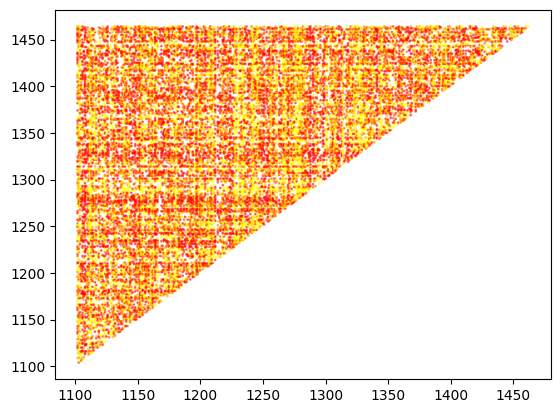

In [26]:
plt.scatter(visualizacao["TeamA"], visualizacao["TeamB"], c= visualizacao["TeamAWins"], cmap=plt.cm.autumn, alpha=0.5, s = 1)
plt.show()

Removendo pontos "seguros" (com taxa de vitória ou derrota altas)

In [27]:
visualizacao_incertos = visualizacao.loc[(visualizacao.TeamAWins > 0.4) & (visualizacao.TeamAWins < 0.6)]
visualizacao_incertos

,TeamA,TeamB,TeamAWins
7,1102,1125,0.500000
12,1102,1142,0.500000
13,1102,1143,0.500000
14,1102,1148,0.500000
17,1102,1154,0.500000
...,...,...,...
22596,1453,1460,0.500000
22601,1454,1460,0.522727
22607,1455,1462,0.500000
22609,1456,1459,0.500000


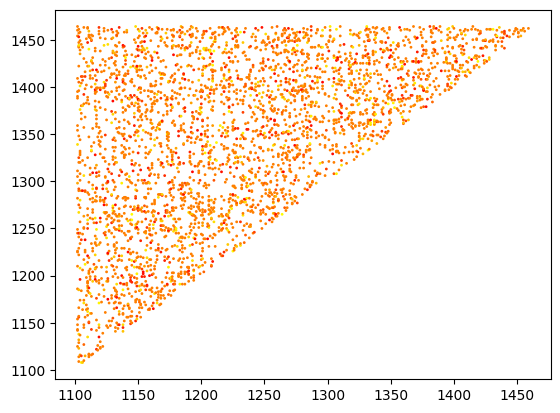

In [28]:
plt.scatter(visualizacao_incertos["TeamA"], visualizacao_incertos["TeamB"], c= visualizacao_incertos["TeamAWins"], cmap=plt.cm.autumn, alpha=1, s = 1)
plt.show()

---

# Previsão utilizando rede e Cadeia de Markov

### Criando a rede

In [29]:
import networkx as nx

G = nx.from_pandas_edgelist(visualizacao, source='TeamA', target='TeamB',
                            edge_attr='TeamAWins') 

In [31]:
visualizacao_copy = visualizacao.copy()
teams = pd.unique(visualizacao_copy[['TeamA', 'TeamB']].values.ravel('K'))
n = len(teams)
n

360

In [32]:
len(df_teams)

364

4 times não apareceram em nenhuma partida até 2014

### Matriz de transição

In [33]:
matrix = np.zeros((n,n))

In [34]:
trans_matrix = pd.DataFrame(matrix, columns = teams, index=teams)

In [35]:
trans_matrix

,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,...,1455,1456,1457,1458,1459,1460,1462,1461,1463,1464
1102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
#Todos os caminhos minimos possiveis entre possibilidades de jogos
erros = 0
i = 0
for team in teams[:]:
    for opponent in teams[i+1:]:
        try:
            probability = 1
            path = nx.shortest_path(G, source=team, target=opponent)
            for source, target in zip(path, path[1:]):
                prob = G[source][target]["TeamAWins"]
                if source < target:
                    probability *= prob
                else:
                    probability *= (1 - prob)
            trans_matrix.loc[trans_matrix.index == path[0], path[-1]] = prob
        except:
            erros += 1 
    i += 1
print(erros)

0


In [114]:
trans_matrix

,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,...,1455,1456,1457,1458,1459,1460,1462,1461,1463,1464
1102,0.0,0.5,1.0,0.586207,0.553846,1.000000,1.000000,0.833333,0.827586,0.5,...,0.00,0.00000,0.0,0.0,0.666667,0.50,0.00,0.301587,1.0,0.500000
1103,0.0,0.0,0.0,1.000000,1.000000,0.480000,0.111111,0.500000,1.000000,1.0,...,0.75,0.00000,0.5,0.5,1.000000,0.75,0.00,0.500000,1.0,0.814815
1104,0.0,0.0,0.0,1.000000,1.000000,0.307692,0.586207,0.500000,1.000000,1.0,...,0.75,0.00000,1.0,0.5,1.000000,0.75,0.75,0.500000,1.0,1.000000
1105,0.0,0.0,0.0,0.000000,0.264706,1.000000,0.586207,0.000000,1.000000,1.0,...,0.00,1.00000,1.0,0.5,1.000000,0.00,0.75,0.000000,1.0,1.000000
1106,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.553846,0.000000,1.000000,1.0,...,0.75,0.74359,1.0,0.5,1.000000,0.00,0.75,0.000000,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.40,0.301587,1.0,0.825000
1462,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.00,0.301587,1.0,1.000000
1461,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.00,0.000000,1.0,0.500000
1463,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00,0.00000,0.0,0.0,0.000000,0.00,0.00,0.000000,0.0,0.500000


In [ ]:
# widths = np.array([w for *_, w in G.edges.data('TeamAWins')])

# pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibi

# # nodes
# nx.draw_networkx_nodes(G, pos)

# # edges
# nx.draw_networkx_edges(G, pos, width=widths)  

# # labels
# nx.draw_networkx_labels(G, pos, font_family="sans-serif")

# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()

---

# Utilizando regressão logística

In [38]:
df = df.astype({"TeamA": str, "TeamB": str})
df = df.drop(columns=['Mandante', "Season"])

In [39]:
from sklearn.linear_model import LogisticRegression
RANDOM_SEED = 42
train_set, test_set = train_test_split(
    df,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

X_train = train_set.drop(columns=['TeamAWins'])
y_train = train_set['TeamAWins']

X_test = test_set.drop(columns=['TeamAWins'])
y_test = test_set['TeamAWins']

In [40]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7308381977032543

### Curva ROC

As probabilidades preditas do time A ganhar são mostradas abaixo

In [42]:
y_pred_prob = model.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]
y_pred_prob

array([0.2461043 , 0.11520427, 0.3336038 , ..., 0.58903171, 0.45915825,
       0.73143617])

In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc_score(y_test, y_pred_prob)

0.8062120022948639

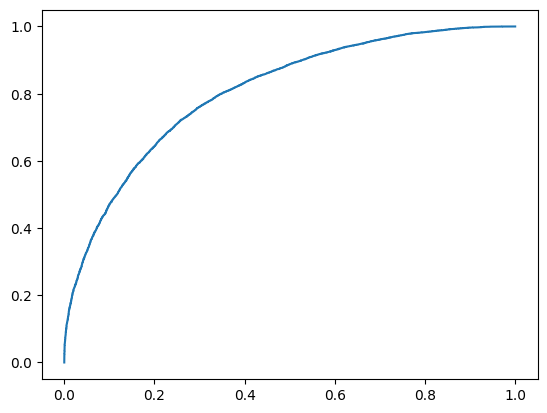

In [44]:
plt.plot(fpr, tpr)

---

# Prevendo os jogos de 2014

In [58]:
SampleSubmissionStage1_copy = SampleSubmissionStage1.copy()

In [59]:
SampleSubmissionStage1_copy[['Season', 'TeamA', 'TeamB']] = SampleSubmissionStage1_copy['ID'].str.split(pat = '_', expand = True)
SampleSubmissionStage1_copy

,ID,Pred,Season,TeamA,TeamB
0,2014_1107_1110,0.5,2014,1107,1110
1,2014_1107_1112,0.5,2014,1107,1112
2,2014_1107_1113,0.5,2014,1107,1113
3,2014_1107_1124,0.5,2014,1107,1124
4,2014_1107_1140,0.5,2014,1107,1140
...,...,...,...,...,...
9107,2017_1455_1458,0.5,2017,1455,1458
9108,2017_1455_1462,0.5,2017,1455,1462
9109,2017_1457_1458,0.5,2017,1457,1458
9110,2017_1457_1462,0.5,2017,1457,1462


In [60]:
season_2014 = SampleSubmissionStage1_copy.loc[SampleSubmissionStage1_copy['Season']=="2014"]
season_2014

,ID,Pred,Season,TeamA,TeamB
0,2014_1107_1110,0.5,2014,1107,1110
1,2014_1107_1112,0.5,2014,1107,1112
2,2014_1107_1113,0.5,2014,1107,1113
3,2014_1107_1124,0.5,2014,1107,1124
4,2014_1107_1140,0.5,2014,1107,1140
...,...,...,...,...,...
2273,2014_1455_1459,0.5,2014,1455,1459
2274,2014_1455_1462,0.5,2014,1455,1462
2275,2014_1458_1459,0.5,2014,1458,1459
2276,2014_1458_1462,0.5,2014,1458,1462


### Utilizando a matriz de transição

In [116]:
matrix_predictions = season_2014.copy()

In [117]:
for index, row in matrix_predictions.iterrows():
    matrix_predictions.loc[(matrix_predictions['TeamA'] == row['TeamA'])&(matrix_predictions['TeamB'] == row['TeamB']), 'Pred'] = trans_matrix.loc[trans_matrix.index == int(row['TeamA']), int(row['TeamB'])].values[0]

In [118]:
matrix_predictions

,ID,Pred,Season,TeamA,TeamB
0,2014_1107_1110,0.500000,2014,1107,1110
1,2014_1107_1112,1.000000,2014,1107,1112
2,2014_1107_1113,0.000000,2014,1107,1113
3,2014_1107_1124,0.000000,2014,1107,1124
4,2014_1107_1140,0.400000,2014,1107,1140
...,...,...,...,...,...
2273,2014_1455_1459,0.666667,2014,1455,1459
2274,2014_1455_1462,0.500000,2014,1455,1462
2275,2014_1458_1459,1.000000,2014,1458,1459
2276,2014_1458_1462,0.333333,2014,1458,1462


Verificar resultados!

### Utilizando o modelo de regressão logística

Precisa dos elos dos times em 2014 para passar pro modelo de regressão